In [17]:
import numpy as np
import matplotlib.pyplot as plt

from fastprogress import progress_bar

import jlinops

# Homogeneous variance

In [15]:
n = 100
mask = np.random.binomial(1, p=0.1, size=n)
F = jlinops.Subsampling1DOperator(mask)
F = jlinops.black_box_to_dense(F)

In [18]:
def vget_rho(reg_lambdas, ps, n_samples=200, eps=1e-1, n=100):

    output_rhos = np.zeros_like(reg_lambdas)
    p, q = reg_lambdas.shape

    R, W = jlinops.first_order_derivative_1d(n, boundary="zero")
    _R = R.toarray()


    for i in progress_bar(range(p)):

        for j in range(q):

            reg_lambda = reg_lambdas[i,j]
            p = ps[i,j]
          
            rho_ests = []
            for k in range(n_samples):

                mask = np.random.binomial(1, p=p, size=n)
                F = jlinops.Subsampling1DOperator(mask)
                F = jlinops.black_box_to_dense(F)
                R = np.sqrt(reg_lambda)*_R
    
                # Get spectrum of original problem
                Q1 = (F.T @ F) + (R.T @ R)
                Q1_cond = np.linalg.cond(Q1)
       
                # Get spectrum for transformed problem
                Rpinv = np.linalg.pinv( R )
                Q2 = np.eye(R.shape[0]) + (Rpinv.T @ F.T @ F @ Rpinv)
                Q2_cond = np.linalg.cond(Q2)
     
                # Improvement factor
                rho = Q1_cond/Q2_cond
                rho_ests.append(rho)

            mean_rho = np.mean(rho_ests)
            output_rhos[i,j] = mean_rho

            # print("finished one")
            

    return output_rhos

In [19]:
# Define the range and grid density for the parameters
# x =  np.float64(np.arange(start=1, stop=100, step=3)) # blur
# y =  np.arange(start=0, stop=100, step=5) # number of nonsparse components

x = np.logspace(-4, 3, num=20) # reg_lambdas
y =  np.linspace(0.0, 1.0, 20) # ps

# Create a meshgrid for the parameters
X, Y = np.meshgrid(x, y)

In [30]:
# Compute the function values
Z = vget_rho(X, Y, n_samples=100, eps=1e-2)

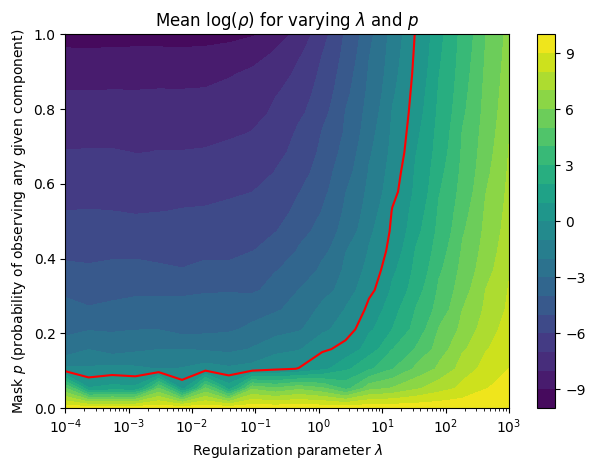

In [35]:
# Create the heatmap
plt.contourf(X, Y, np.log(Z), 20, cmap='viridis')
# Add a color bar to show the scale
plt.colorbar()

plt.contour(X, Y, np.log(Z), levels=[0.0], colors='red')
plt.xscale("log")


# Add labels and title if desired
plt.xlabel('Regularization parameter $\lambda$')
plt.ylabel('Mask $p$ (probability of observing any given component)')
plt.title('Mean $\log(\\rho)$ for varying $\lambda$ and $p$')
plt.tight_layout()
plt.savefig("subsampling_conditioning_varying_reg_p.png", dpi=250, bbox_inches="tight")
plt.savefig("subsampling_conditioning_varying_reg_p.eps", bbox_inches="tight")
# Show the plot
plt.show()

# Inhomogeneous variance

In [39]:
def rand_theta(n, num_nsparse, eps=1e-1, reg_lambda=1.0):
    assert num_nsparse <= n, "num_nsparse must be less than or equal to n."

    if num_nsparse < n:
        result = eps*np.ones(n)
        nsparse_idxs = np.random.choice( [i for i in range(n)], size=num_nsparse, replace=False )
        result[nsparse_idxs] = np.ones(num_nsparse)
        result = result/reg_lambda
    else:
        result = np.ones(num_nsparse)

    return result

In [40]:
def vget_rho(reg_lambdas, knsparses, n_samples=200, eps=1e-1, n=100, prob=0.5):

    output_rhos = np.zeros_like(reg_lambdas)
    p, q = reg_lambdas.shape

    R, W = jlinops.first_order_derivative_1d(n, boundary="zero")
    _R = R.toarray()


    for i in progress_bar(range(p)):

        for j in range(q):

            reg_lambda = reg_lambdas[i,j]
            knsparse = knsparses[i,j]
          
            rho_ests = []
            for k in range(n_samples):

                mask = np.random.binomial(1, p=prob, size=n)
                theta = rand_theta(n, num_nsparse=knsparse, eps=eps, reg_lambda=reg_lambda)
                F = jlinops.Subsampling1DOperator(mask)
                F = jlinops.black_box_to_dense(F)
                R = np.diag(1.0/np.sqrt(theta)) @ _R # put in the weights
    
                # Get spectrum of original problem
                Q1 = (F.T @ F) + (R.T @ R)
                Q1_cond = np.linalg.cond(Q1)
       
                # Get spectrum for transformed problem
                Rpinv = np.linalg.pinv( R )
                Q2 = np.eye(R.shape[0]) + (Rpinv.T @ F.T @ F @ Rpinv)
                Q2_cond = np.linalg.cond(Q2)
     
                # Improvement factor
                rho = Q1_cond/Q2_cond
                rho_ests.append(rho)

            mean_rho = np.mean(rho_ests)
            output_rhos[i,j] = mean_rho

            # print("finished one")
            

    return output_rhos

In [41]:
# Define the range and grid density for the parameters
# x =  np.float64(np.arange(start=1, stop=100, step=3)) # blur
# y =  np.arange(start=0, stop=100, step=5) # number of nonsparse components

x = np.logspace(-4, 3, num=20) # reg_lambdas
y =  np.arange(start=0, stop=101, step=1) # number of nonsparse components


# Create a meshgrid for the parameters
X, Y = np.meshgrid(x, y)

In [42]:
# Compute the function values
Z = vget_rho(X, Y, n_samples=100, eps=1e-2)

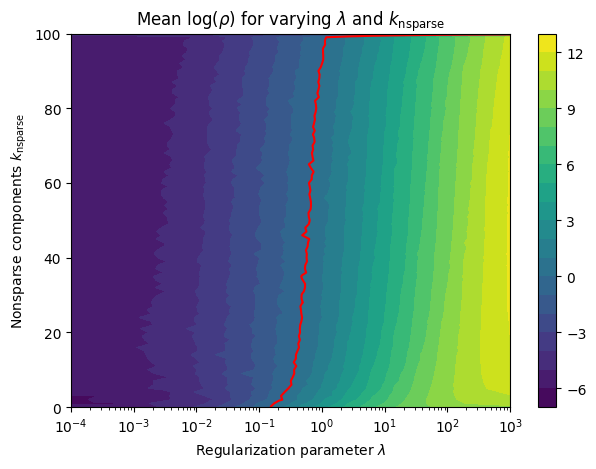

In [44]:
# Create the heatmap
plt.contourf(X, Y, np.log(Z), 20, cmap='viridis')
# Add a color bar to show the scale
plt.colorbar()

plt.contour(X, Y, np.log(Z), levels=[0.0], colors='red')
plt.xscale("log")


# Add labels and title if desired
plt.xlabel('Regularization parameter $\lambda$')
plt.ylabel('Nonsparse components $k_{\\text{nsparse}}$')
plt.title('Mean $\log(\\rho)$ for varying $\lambda$ and $k_{\\text{nsparse}}$')
plt.tight_layout()
plt.savefig("sparsity_subsampling_conditioning_varying_reg_nsparse.png", dpi=250, bbox_inches="tight")
plt.savefig("sparsity_subsampling_conditioning_varying_reg_nsparse.eps", bbox_inches="tight")
# Show the plot
plt.show()